In [1]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from dnafiber.deployment import ENSEMBLE, Models, run_one_file
from dnafiber.inference import _get_model

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

# Deactivate pandas FutureWarning
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-09-02 13:58:39.044 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 13:58:39.759 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 13:58:39.760 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_input

In [2]:
Models.UNET_MOBILEONE_S0

<Models.UNET_MOBILEONE_S0: 'unet_mobileone_s0'>

In [3]:
root = Path("/home/clement/Documents/data/DNAFiber/Input/")
output = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/")
output.mkdir(exist_ok=True, parents=True)
all_files = list(root.rglob("*.czi"))
for file in tqdm(all_files, total=len(all_files)):
    path_from_input = file.relative_to(root)
    output_file = output / path_from_input.with_suffix(".csv")
    if output_file.exists():
        continue  # Skip if the output file already exists
    df = run_one_file(file, model=ENSEMBLE, verbose=True, use_tta=False).to_df(
        img_name=file.stem, filter_invalid=False
    )
    output_file.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(output_file, index=False)

  0%|          | 0/248 [00:00<?, ?it/s]

In [4]:
palette = ["#81c8be", "#ef9f76"]

In [5]:
import matplotlib.pyplot as plt
from experiments import exp1, exp2, exp3, exp4, exp5

root = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/YM-2025-20/")


df1, pairs1 = exp1("OutputEnsembleV2/YM-2025-20/", "YM-2025-20.xlsx")
df2, pairs2 = exp2("OutputEnsembleV2/YM-2025-16/", "YM-2025-16.xlsx")
df3, pairs3 = exp3("OutputEnsembleV2/YM-2025-17/", "YM-2025-17.xlsx")
df4, pairs4 = exp4(
    "OutputEnsembleV2/YM-2025-21-22/", ["YM-2025-21.xlsx", "YM-2025-22.xlsx"]
)
df5, pairs5 = exp5("OutputEnsembleV2/YM-2025-25/", "YM-2025-25.xlsx")

['siBRCA2_12.5' 'si53BP1_5' 'siNT' 'si53BP1_7.5' 'siBRCA2_7.5'
 'si53BP1_12.5' 'siBRCA2_5']


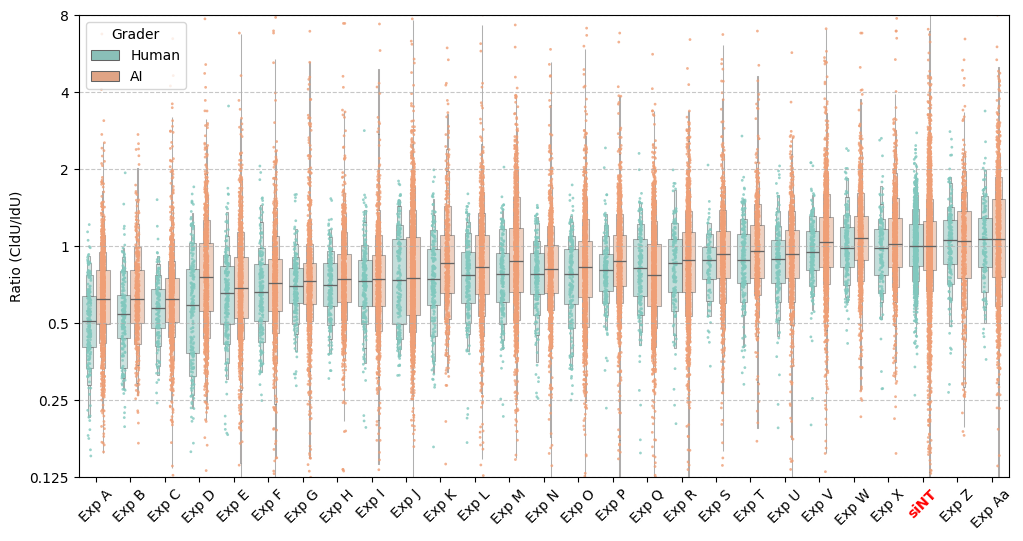

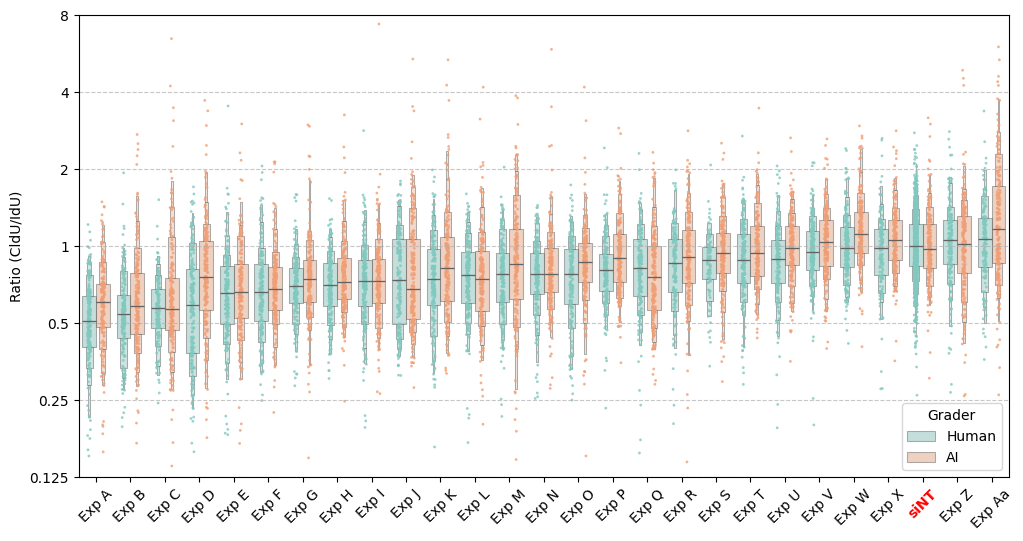

In [6]:
import string

from dnafiber.analysis.ratios import (
    compare_pairs,
    create_boxen_plot,
    create_boxen_swarmplot,
    normalize_df,
    select_N_closest_to_mean,
    select_N_closest_to_median,
    graders_statistical_test,
)

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
fig, ax = plt.subplots(figsize=(12, 6))


normalize_df(df, "siNT")
# Relabel the type to anonymous labels (e.g., 'A', 'B', 'C' etc.)
alphabet = list(string.ascii_uppercase) + [
    a + b for a in string.ascii_uppercase for b in string.ascii_lowercase
]


# Reorder the 'Type' categories based on the median 'Ratio' values
type_order = (
    df[df.Grader == "Human"].groupby("Type")["Ratio"].median().sort_values().index
)
df["Type"] = pd.Categorical(df["Type"], categories=type_order, ordered=True)
type_mapping = {
    original_type: f"Exp {alphabet[i]}"
    for i, original_type in enumerate((df["Type"].cat.categories))
    if original_type != "siNT"
}
type_mapping["siNT"] = "siNT"
df["Type"] = df["Type"].map(type_mapping)
create_boxen_swarmplot(
    df,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    dodge=True,
    size=2,
)

# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == "siNT":
        xtick.set_color("red")
        xtick.set_fontweight("bold")

# Remove the alpha from the legend markers
handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
    # Increase the size of the legend markers
    if hasattr(handle, "set_sizes"):
        handle.set_sizes([10])
    elif hasattr(handle, "set_markersize"):
        handle.set_markersize(10)
plt.legend(handles, labels, title="Grader", loc="upper left")
plt.ylabel("Ratio (CldU/IdU)")
plt.savefig("figures/boxen_swarmplot_all.png", dpi=300, bbox_inches="tight")
plt.show()

# df_select = select_N_closest_to_mean(df, N=None, column="Length")
df_select = select_N_closest_to_median(df, N=None, column="Length")
plt.figure(figsize=(12, 6))

create_boxen_swarmplot(
    df_select,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    dodge=True,
    size=2,
)
# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == "siNT":
        xtick.set_color("red")
        xtick.set_fontweight("bold")


plt.ylabel("Ratio (CldU/IdU)")
plt.savefig("figures/boxen_swarmplot_all_selected.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1325022/3463391280.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_human["Type"] = pd.Categorical(df_human["Type"], categories=type_order, ordered=True)
/tmp/ipykernel_1325022/3463391280.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["Type"] = pd.Categorical(df_ai["Type"], categories=type_order, ordered=True)
/tmp/ipykernel_1325022/3463391280.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

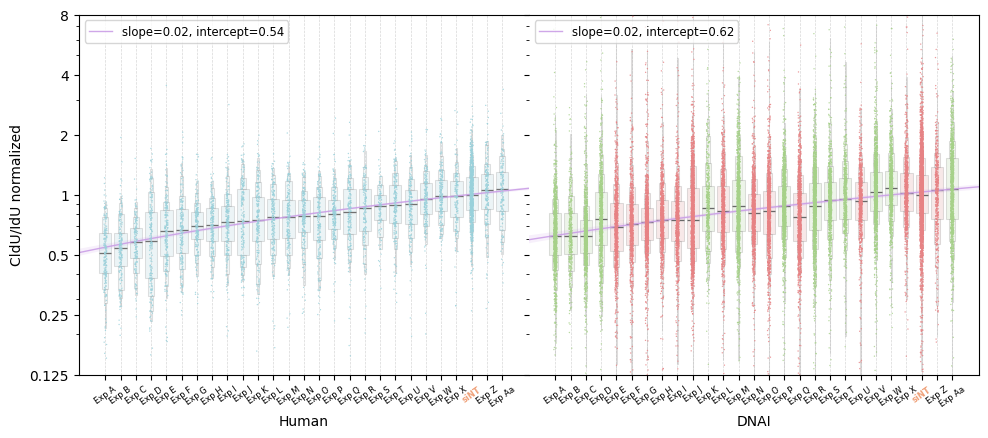

In [7]:
import string
from scipy.stats import linregress
from dnafiber.analysis.ratios import (
    compare_pairs,
    create_boxen_plot,
    create_boxen_swarmplot,
    normalize_df,
    select_N_closest_to_mean,
    select_N_closest_to_median,
)

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

normalize_df(df, "siNT")
# df = select_N_closest_to_mean(df, N=None, column="Length")
alphabet = list(string.ascii_uppercase) + [
    a + b for a in string.ascii_uppercase for b in string.ascii_lowercase
]


df_human = df[df.Grader == "Human"]
df_ai = df[df.Grader == "AI"]
# Relabel the type to anonymous labels (e.g., 'A', 'B', 'C' etc.)

type_order = df_human.groupby("Type")["Ratio"].median().sort_values().index

ai_medians = df_ai.groupby("Type")["Ratio"].median()
ai_type_order = ai_medians.sort_values().index

good_color = "#a6d189"
bad_color = "#e78284"
epsilon = 1e-2
palette = []
for i, order in enumerate(type_order):
    if i == 0:
        if ai_medians[order] <= ai_medians.min() + epsilon:
            palette.append(good_color)
        else:
            palette.append(bad_color)
        continue
    if i == len(type_order) - 1:
        if ai_medians[order] >= ai_medians.max() - epsilon:
            palette.append(good_color)
        else:
            palette.append(bad_color)
        continue

    previous_orders = type_order[:i]
    if any(
        ai_medians[order] < ai_medians[prev_order] for prev_order in previous_orders
    ):
        palette.append(bad_color)
    else:
        palette.append(good_color)

df_human["Type"] = pd.Categorical(df_human["Type"], categories=type_order, ordered=True)
df_ai["Type"] = pd.Categorical(df_ai["Type"], categories=type_order, ordered=True)

type_order_remapped = [
    "Exp " + alphabet[type_order.get_loc(x)] if x != "siNT" else "siNT"
    for x in type_order
]

for i, (ax, (df_subset, title)) in enumerate(
    zip(axes, [(df_human, "Human"), (df_ai, "DNAI")])
):
    df_subset["Type"] = (
        df_subset["Type"]
        .map(
            lambda x: "Exp " + alphabet[type_order.get_loc(x)]
            if x != "siNT"
            else "siNT"
        )
        .copy()
    )
    if i == 0:
        p = ["#99d1db"]
    else:
        p = palette
    _ = sns.boxenplot(
        data=df_subset,
        x="Type",
        y="Ratio",
        palette=p,
        log_scale=True,
        ax=ax,
        showfliers=False,
        alpha=0.2,
    )
    _ = sns.stripplot(
        data=df_subset,
        x="Type",
        y="Ratio",
        color="black",
        size=1,
        ax=ax,
        alpha=0.8,
        palette=p,
    )

    x = []
    y = []
    medians = df_subset.groupby("Type")["Ratio"].median()
    for order in type_order_remapped:
        x.append(medians.index.get_loc(order))
        y.append(medians[order])
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)

    # Create regression plot with custom label
    _ = sns.regplot(
        x=x,
        y=y,
        scatter=False,
        ax=ax,
        truncate=False,
        line_kws={"color": "#ca9ee6", "alpha": 0.9, "lw": 1},
        label=f"slope={slope:.2f}, intercept={intercept:.2f}",
    )
    ax.set_yticks(
        ticks=[0.125, 0.25, 0.5, 1, 2, 4, 8], labels=[0.125, 0.25, 0.5, 1, 2, 4, 8]
    )
    ax.set_ylim(0.125, 8)
    ax.set_xlabel(title)
    ax.margins(x=0)

    ax.set_xticks(range(len(df_subset["Type"].cat.categories)))
    ax.set_xticklabels(df_subset["Type"].cat.categories, rotation=35, size=6)
    ax.margins(x=0)

    xticks = ax.get_xticklabels()
    for xtick in xticks:
        if xtick.get_text() == "siNT":
            xtick.set_color("#ef9f76")
            xtick.set_fontweight("bold")
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    # Add legend with only the regression line info
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:], loc="upper left", fontsize="small")
    if i == 0:
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["left"].set_visible(False)

    ax.set_ylabel("CldU/IdU normalized")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0, hspace=0.1)

plt.margins(x=0)
# plt.savefig("Zeiss_comparison_side_by_side_all.png", dpi=300, bbox_inches='tight')

plt.savefig(
    "Zeiss_comparison_side_by_side_only_selected.png", dpi=300, bbox_inches="tight"
)
plt.show()


/tmp/ipykernel_1325022/2730814581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_sint_sibrca1["Type"] = df1_sint_sibrca1["Type"].cat.remove_unused_categories()


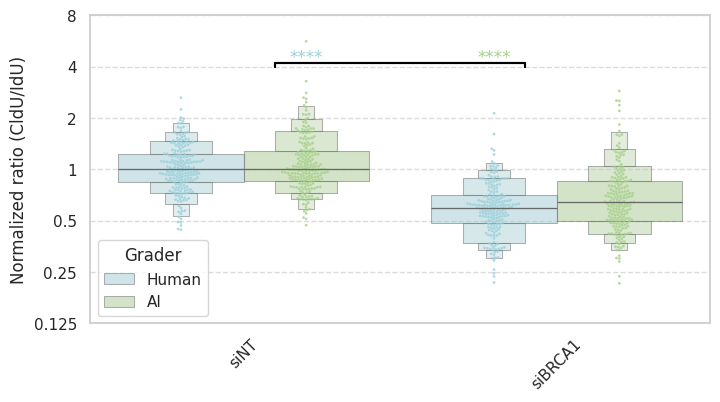

In [30]:
df1_sint_sibrca1 = df1[
    # (df1["Ratio"] < 8)
    # & (df1["Ratio"] > 0.125)
    (df1["Valid"])
    & (df1["Type"].isin(["siNT", "siBRCA1"]))
]

palette = ["#99d1db", "#a6d189"]
df1_sint_sibrca1["Type"] = df1_sint_sibrca1["Type"].cat.remove_unused_categories()
df1_sint_sibrca1 = select_N_closest_to_median(df1_sint_sibrca1, N=200, column="Length")

plt.figure(figsize=(8, 4))
normalize_df(df1_sint_sibrca1, "siNT")
create_boxen_swarmplot(df1_sint_sibrca1, palette=palette, dodge=True, size=2)
# graders_statistical_test(df1_sint_sibrca1)
compare_pairs(df1_sint_sibrca1, palette=palette, pairs=[("siNT", "siBRCA1", -2)])
plt.ylabel("Normalized ratio (CldU/IdU)")
plt.ylim(0.125, 8)
plt.savefig("figures/boxen_swarmplot_siNT_siBRCA1.png", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_1325022/331494935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_sint_sibrca1["Type"] = df5_sint_sibrca1["Type"].cat.remove_unused_categories()


TypeError: xlabel() missing 1 required positional argument: 'xlabel'

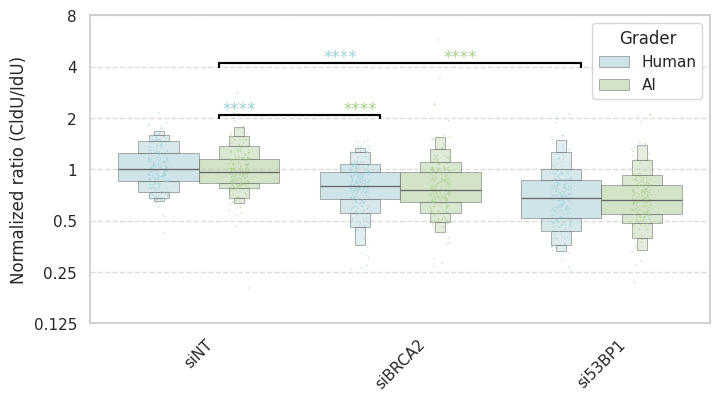

In [ ]:
# df5_sint_sibrca1 = df5[df5["Ratio"] < 8]
# df5_sint_sibrca1 = df5[df5["Ratio"] > 0.125]

df5_sint_sibrca1 = df5[df5["Valid"]]
df5_sint_sibrca1 = df5[df5["Type"].isin(["siNT", "siBRCA2_5", "si53BP1_12.5"])]
df5_sint_sibrca1["Type"] = df5_sint_sibrca1["Type"].cat.remove_unused_categories()

normalize_df(df5_sint_sibrca1, "siNT")
df5_sint_sibrca1 = select_N_closest_to_median(df5_sint_sibrca1, N=None, column="Length")

df5_sint_sibrca1["Type"] = df5_sint_sibrca1["Type"].map(
    {"siNT": "siNT", "siBRCA2_5": "siBRCA2", "si53BP1_12.5": "si53BP1"}
)
plt.figure(figsize=(8, 4))

create_boxen_swarmplot(
    df5_sint_sibrca1, palette=palette, dodge=True, size=1, stripplot=True, rotate_xticks=0
)
# graders_statistical_test(df5_sint_sibrca1)
pairs = [
    ("siNT", p2, -6 + 2 ** (i))
    for i, p2 in enumerate(df5_sint_sibrca1["Type"].unique())
    if p2 != "siNT"
]
compare_pairs(df5_sint_sibrca1, palette=palette, pairs=pairs)

plt.ylim(0.125, 8)
plt.ylabel("Normalized ratio (CldU/IdU)")

plt.savefig("figures/boxen_swarmplot_exp5.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1325022/3580735546.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


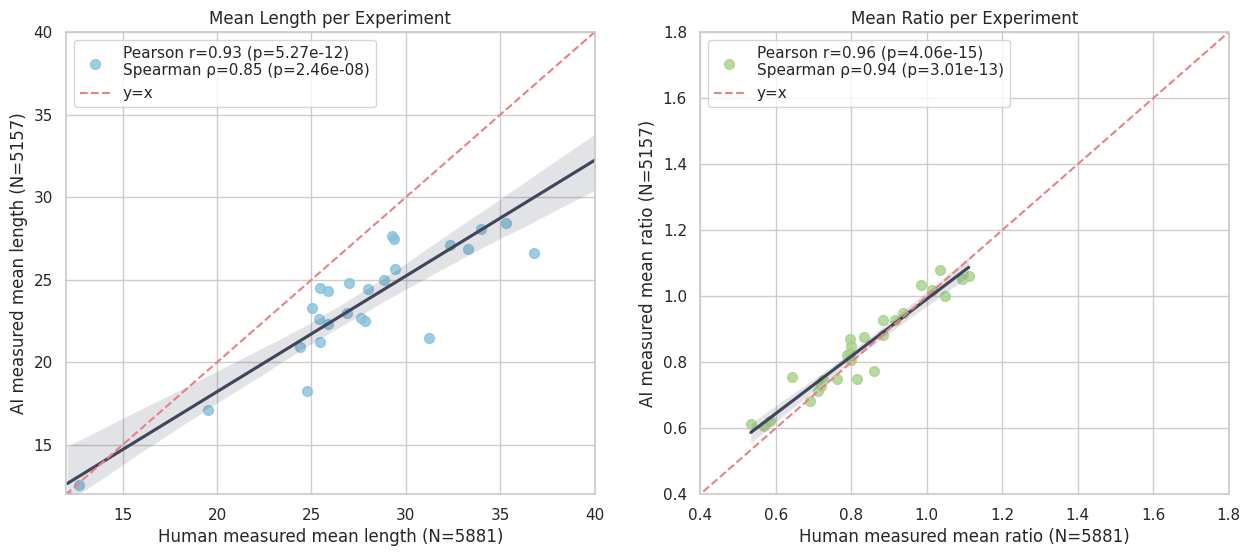

In [12]:
from scipy.stats import pearsonr, spearmanr

df_select = select_N_closest_to_median(df, N=None, column="Ratio")

x = df[df["Grader"] == "Human"]
y = df[df["Grader"] == "AI"]

x = df_select[df_select["Grader"] == "Human"]
y = df_select[df_select["Grader"] == "AI"]
grouped_x = x.groupby("Type")
grouped_y = y.groupby("Type")
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (measure, yrange, color) in enumerate(
    [("Length", (12, 40), "#85c1dc"), ("Ratio", (0.4, 1.8), "#a6d189")]
):
    rho = pearsonr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    phi = spearmanr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    sns.regplot(
        x=grouped_x[f"{measure}"].mean(),
        y=grouped_y[f"{measure}"].mean(),
        scatter_kws={"s": 50},
        line_kws={"color": "#414559"},
        color=color,
        label=f"Pearson r={rho[0]:.2f} (p={rho[1]:.2e})\nSpearman ρ={phi[0]:.2f} (p={phi[1]:.2e})",
        ax=axes[i],
    )
    axes[i].set_xlabel(f"Human measured mean {measure.lower()} (N={len(x)})")
    axes[i].set_ylabel(f"AI measured mean {measure.lower()} (N={len(y)})")

    axes[i].set_title(f"Mean {measure} per Experiment")
    axes[i].plot([0, 40], [0, 40], color="#e78284", linestyle="--", label="y=x")
    axes[i].legend()

    axes[i].set_ylim(yrange)
    axes[i].set_xlim(yrange)

fig.show()
fig.savefig("figures/ai_vs_human_length_ratio.png", dpi=300)

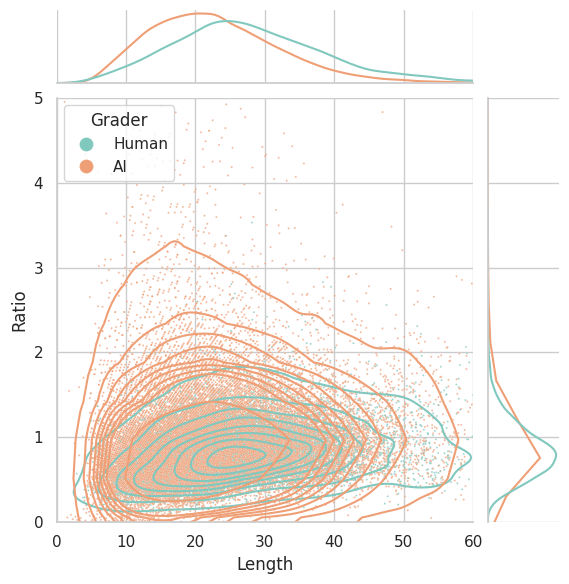

In [13]:
palette = ["#81c8be", "#ef9f76"]
g = sns.jointplot(
    data=df,
    x="Length",
    y="Ratio",
    hue="Grader",
    kind="kde",
    palette=palette,
    marginal_kws={"common_norm": False},
)
#   common_norm=False, fill=True, multiple="stack", common_grid=True,)
g.plot_joint(sns.scatterplot, s=2, alpha=0.75)
# Change the size and alpha of the legend markers

handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
    # Increase the size of the legend markers
    if hasattr(handle, "set_sizes"):
        handle.set_sizes([10])
    elif hasattr(handle, "set_markersize"):
        handle.set_markersize(10)
plt.legend(handles, labels, title="Grader", loc="upper left")

plt.xlim(0, 60)
plt.ylim(0, 5)
plt.savefig("figures/length_vs_ratio_kde.png", dpi=300)

In [14]:
#